In [1]:
import os
import sys
import warnings
import iris.plot as iplt
import glob as glob
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.path as mpltPath
import pyproj
from pyproj import CRS

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

##################################################################
# Load necessary spatial data
##################################################################
# Don't really understand why we need this
def explode_polygon(indata):
    indf = indata
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            #note: now redundant, but function originally worked on
            #a shapefile which could have combinations of individual polygons
            #and MultiPolygons
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

In [2]:
# Load necessary spatial data
# This is a square area surrounding Leeds
gb_gdf = create_gb_outline({'init' :'epsg:4326'})
uk_gdf = create_uk_outline({'init' :'epsg:4326'})

In [3]:
# Explode the gdf MultiPolygon into its constituents
gb_gdf_exploded=explode_polygon(gb_gdf)
uk_gdf_exploded=explode_polygon(uk_gdf)

## UKCP18 mask
### Load example UKCP18 data - 2.2km

In [4]:
filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19950801-19950830.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]

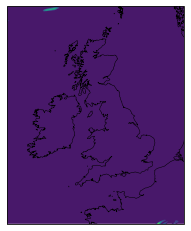

In [5]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Trim to GB

In [6]:
cube_onets = trim_to_bbox_of_region_regriddedobs(cube_onets, gb_gdf)

### Create list of lat/lon locations

In [7]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat2d=cube_onets.coord('latitude').points
lon2d = cube_onets.coord('longitude').points

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        point=(lon2d[latit,lonit],lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [8]:
#Loop over each individual polygon and get external coordinates
for index,row in gb_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

print ('fininshed checking for points inside all polygons')

KeyboardInterrupt: 

### Check if it worked

In [ ]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]
cube_onets = trim_to_bbox_of_region_regriddedobs(cube_onets, gb_gdf)

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Save the mask

In [3]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_5km_GB_Mask.npy', mask.data)

## Create 2.2km BNG mask
### Load example data

In [25]:
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km/bc005/2002_2020/bc005a.pr200508*')[0][1,:,:]
sample_cube.shape

(606, 484)

In [22]:
filename = '/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng/01/1980_2001/bng_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19810801-19810830.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


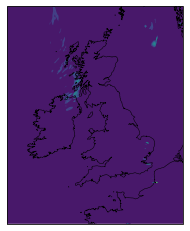

In [10]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [20]:
cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')
cube_onets.shape

(521, 424)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


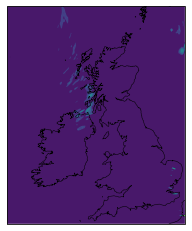

In [12]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [15]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [16]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

In [17]:
# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

#Loop over each individual polygon and get external coordinates
for index,row in uk_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

### Check if it worked

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


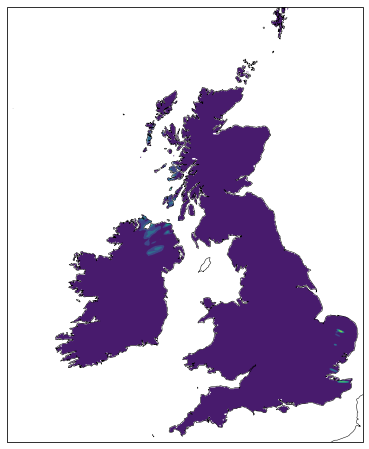

In [18]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]
cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [19]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_bng_GB_Mask.npy', mask.data)

## Create 2.2_regridded_12km BNG mask
### Load example data

In [8]:
filename = '/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng_regridded_12km/01/AreaWeighted/1980_2001/bng_rg_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19810801-19810830.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]

In [ ]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [10]:
cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


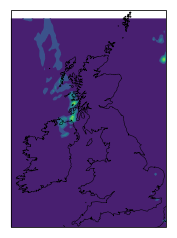

In [11]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [ ]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

In [13]:
# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

#Loop over each individual polygon and get external coordinates
for index,row in uk_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

### check if it worked

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


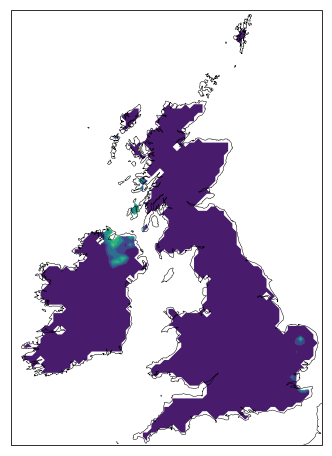

In [30]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]
cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Save

In [31]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_bng_GB_Mask.npy', mask.data)

## Create 2.2_regridded_12km WGS84 mask
### Load example data

In [15]:
filename = '/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_regridded_12km/01/AreaWeighted/1980_2001/wgs84_rg_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19810801-19810830.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]

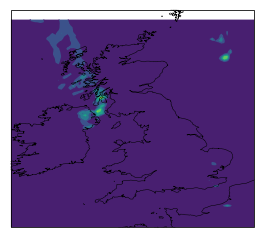

In [16]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [18]:
cube_onets = trim_to_bbox_of_region_wgs84(cube_onets, gb_gdf, 'latitude', 'longitude')

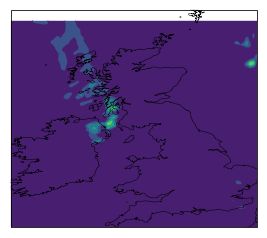

In [19]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [20]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('latitude').points
lon1d = cube_onets.coord('longitude').points

In [21]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

In [40]:
bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lon2d[latit,lonit], lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [43]:
#Loop over each individual polygon and get external coordinates
for index,row in gb_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

### Check if it worked

In [44]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]
cube_onets = trim_to_bbox_of_region_wgs84(cube_onets, gb_gdf, 'latitude', 'longitude')

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

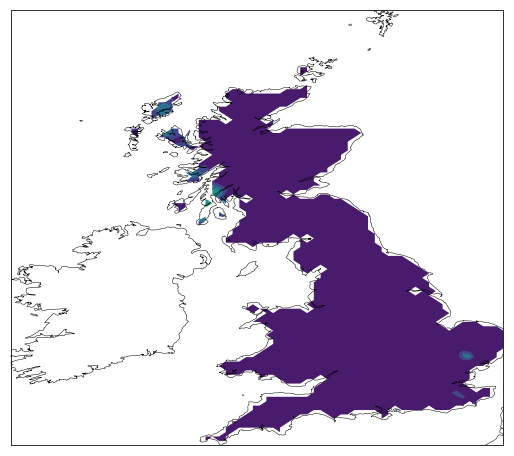

In [46]:
plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [47]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_wgs84_GB_Mask.npy', mask.data)

## Create 12km mask
### Load example data

In [45]:
filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/1980_2001/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
filename ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/pr_rcp85_land-cpm_uk_5km_01_1hr_19810101-19810130.nc'

monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


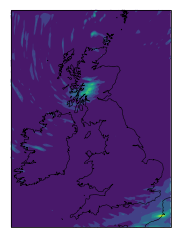

In [46]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [33]:
# cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

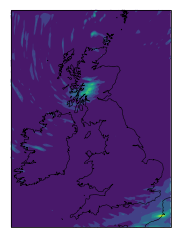

In [47]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [48]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [49]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

In [50]:
bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [51]:
#Loop over each individual polygon and get external coordinates
for index,row in uk_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

### Check if it worked

In [56]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]
# cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf)

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


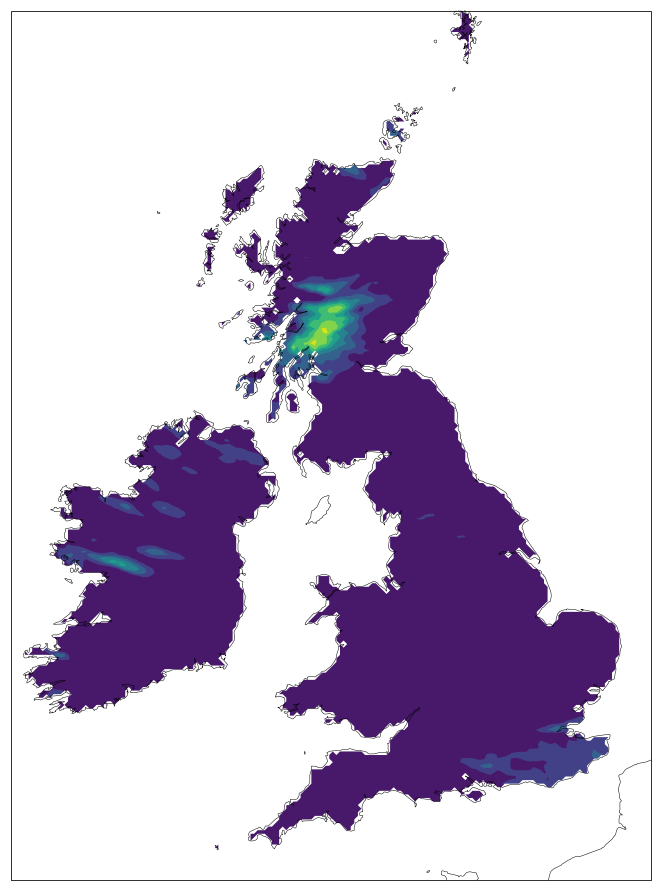

In [57]:
plt.figure(figsize=(20, 16))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Save

In [58]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_5km_UK_Mask.npy', mask.data)

### Compare to land sea mask

In [140]:
# lsm = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
# lsm = lsm[0]
# lsm_nn =lsm.regrid(cube_onets, iris.analysis.Nearest())   

# broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_onets.shape)
# # broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# # Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
# reversed_array = ~broadcasted_lsm_data.astype(bool)
# masked_cube = iris.util.mask_cube(cube_onets, reversed_array)

In [143]:
# plt.figure(figsize=(20, 16))  # Adjust width and height as needed

# # Plot contourf with Iris
# iplt.contourf(masked_cube)
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [144]:
# plt.figure(figsize=(20, 16))  # Adjust width and height as needed

# # Plot contourf with Iris
# iplt.contourf(lsm_nn)

## Create NIMROD mask
### Load example data

In [204]:
filename = f'/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/2011/metoffice-c-band-rain-radar_uk_20110621_30mins.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]

In [205]:
cube_onets= trim_to_bbox_of_region_obs(cube_onets, gb_gdf)
cube_onets = cube_onets[:1100,200:]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


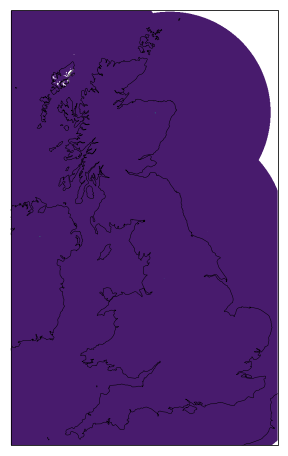

In [206]:
plt.figure(figsize=(10,8)) 
iplt.contourf(cube_onets[:1100,200:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Create list of lat/lon coordinates

In [207]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [208]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

# Step 4: Create mask array
lon_flat = lon2d.flatten()
lat_flat = lat2d.flatten()

In [210]:
bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [211]:
#Loop over each individual polygon and get external coordinates
for index,row in gb_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


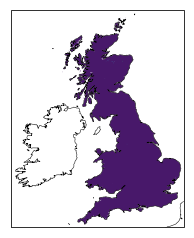

In [214]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]
cube_onets= trim_to_bbox_of_region_obs(cube_onets, gb_gdf)
cube_onets = cube_onets[:1100,200:]

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan
np.unique(cube_onets.data, return_counts=True)

iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [217]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/nimrod_1km_GB_Mask_[1100,200].npy', mask.data)

### Create CEH-GEAR mask

In [29]:
filename = f'/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_199001.nc'
monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[100,:,:]

In [31]:
cube_onets= trim_to_bbox_of_region_obs(cube_onets, gb_gdf)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


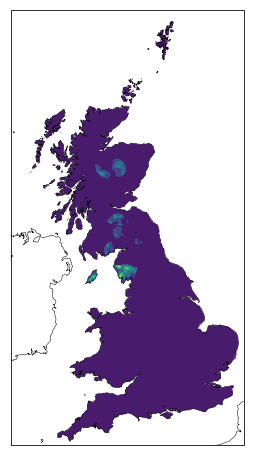

In [32]:
plt.figure(figsize=(10,8)) 
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Create list of lat/lon coordinates

In [33]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [34]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

# Step 4: Create mask array
lon_flat = lon2d.flatten()
lat_flat = lat2d.flatten()

In [35]:
bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [36]:
#Loop over each individual polygon and get external coordinates
for index,row in gb_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

In [ ]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,:,:]
cube_onets= trim_to_bbox_of_region_obs(cube_onets, gb_gdf)
cube_onets = cube_onets[:1100,200:]

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan
np.unique(cube_onets.data, return_counts=True)

iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);